# This notebook (NB) contains the Fake and Real News Classification using LogisticRegression, LSTM,  and XGBoost!

- It is required to place the "True.csv" and "Fake.csv" files inside the "../data" folder!
    - NB: This work was done on a windows machine!
    - I didn't reinvent the wheel in this NB, I am relying on exisiting code for the same or a similar task instead!
    - The NB code contains minor modfications or corrections, which I introduced to suit this problem.
    - Notes were added to the top of each cell to extend readability!
    - Two functions were defined to print the evaluation metrics and and visualize the confusion matrix!

<hr style="height:20px">

# Code References:
##### This NB compares three machine learning (ML) models,  namely:

- LogisticRegression (Baseline)
- LSTM
- XGBoost

##### This work is being based on the work provided in the following GitHub repositories for:

-- LSTM
- https://github.com/cmadusankahw/fake-news-detection-with-LSTM
- https://github.com/krishnaik06/Fake-New-LSTM

-- LogisticRegression
- https://github.com/SushwanthReddy/Fake-News-Detection-using-Machine-Learning

-- XGBoost
- https://github.com/pierobeat/Hoax-News-Classification

## Import the required python libraries!

In [1]:
#!pip install spacy # spaCy is an open-source software library for advanced natural language processing
#!pip install gensim # Gensim is an open-source library for unsupervised topic modeling and natural language processing
#!pip install plotly

#!pip install --upgrade nbformat
#!pip install jupyterthemes

In [2]:
import time

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from string import punctuation

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# import tf and keras - as embedded in tensorflow!
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Dropout, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

## Loading the data

In [3]:
## If it is saved locally!

df_true = pd.read_csv(r"..\data\True.csv")
df_fake = pd.read_csv(r"..\data\Fake.csv")

## From Git or Kaggle under: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset!
#
#df_true = pd.read_csv("https://github.com/cmadusankahw/fake-news-detection-with-LSTM/tree/main/data/True.csv")
#df_fake = pd.read_csv("https://github.com/cmadusankahw/fake-news-detection-with-LSTM/tree/main/data/Fake.csv")

#### Loading the stopwords which is going to be used in data preparation process, and by other ML models

In [4]:
#nltk.download('punkt')

# download stopwords from nltk, only once!
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oalan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Exploratory Data Analysis (EDA): 
- Indicate how many data samples do we have per class (i.e.: Fake and True)
- List how many Null element are present and the memory usage for each dataframe

In [5]:
df_true.shape

(21417, 4)

In [6]:
df_fake.shape

(23481, 4)

In [7]:
#Check if there is a  missing value occurring in the data!

df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [8]:
# Prints metadata information about the true DataFrame!

df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [9]:
#Check if there is a  missing value occurring in the data!

df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
# Prints metadata information about the fake DataFrame!

df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [11]:
# Add a target class column "isreal" to indicate whether the news is real or fake

df_true['isreal'] = 1
df_fake['isreal'] = 0

In [12]:
# Show the top five rows in df_true!

df_true.head()

,title,text,subject,date,isreal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [13]:
# Show the top five rows in df_fake!

df_fake.head()

,title,text,subject,date,isreal
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Data Preparation Process
- Concatenate Real and Fake news dataframes
- Data Cleaning

#### Concatenate Real and Fake News

In [14]:
# Concatenate Real and Fake News!

df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df

,title,text,subject,date,isreal
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [15]:
# drpo unnecessary Date columns!

df.drop(columns = ['date'], inplace = True)

In [16]:
# Combine/concatenate title and text together!

df['original'] = df['title'] + ' ' + df['text']
df.head()

,title,text,subject,isreal,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [17]:
# Explore one full news text - i.e. "original"!

df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

## Data Cleaning
- All punctuation should be removed!
- All stopwords should be removed!
- All numerics should be removed!

In [18]:
# Obtain additional stopwords from nltk,

# Construct English stopwords list!
eng_stopwords = stopwords.words('english') + list(punctuation)

# Extend the list by adding additional stopwords to remove!
eng_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

# Extend the stopwords list by adding an additional stopwords, which were reported by XGBoost - at fitting time!
eng_stopwords.extend(["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'])

In [19]:
len(eng_stopwords)

230

#### Text preprocessing with the help of gensim simple_preprocess()!

In [20]:
# Remove stopwords and remove words with 2 or less characters using gensim!

def text_preprocess(text):
    result = []
    
    # This lowercases and tokenizes the text, it convert a document into a list of lowercases tokens.
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in eng_stopwords:
            result.append(token)
            
    return result

In [21]:
# Apply the "text_preprocess" function to the dataframe

df['clean'] = df['original'].apply(text_preprocess)

In [22]:
# Show original news as it is!

df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [23]:
# Show cleaned up news after removing stopwords (as a list)!

print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [24]:
df.head()

,title,text,subject,isreal,original,clean
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon..."


In [25]:
# Obtain the total words present in the dataset, as we need to find the vocabulary size!

list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [26]:
# After cleansing, the corpus has: 9276947 words (i.e. tokens)!

print(len(list_of_words))

9268087


In [27]:
# Obtain the total number of "UNIQUE" words - using set()!

total_words = len(list(set(list_of_words)))
total_words

108703

In [28]:
# Get rid of list contained in "clean" column - i.e. join the words into a string (words seperated by " "!
# Add a new column that contains the resulting string

df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))

In [29]:
display(df)

,title,text,subject,isreal,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,0,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treated,...",mcpain john mccain furious iran treated sailor...
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justice, yahoo, settles, mail, privacy, class...",justice yahoo settles mail privacy class actio...
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, allied, safe, zone, plan, territor...",sunnistan allied safe zone plan territorial bo...
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,0,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, finally, cal...",blow million jazeera america finally calls qui...


In [30]:
df['clean_joined'][0]

'budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying government raise perce

### If needed - save the clean_joined df as csv (to be used by other models later)!

In [31]:
# Create a minimized dataframe that contains the dependent and independent variables only!

title_df = df[['title', 'isreal']]

# If needed, save this dataframe (with 44898 rows) - run only once!
#title_df.to_csv(r"..\data\title_df.csv")

## Data Visualization 

In [32]:
df.head()

,title,text,subject,isreal,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


<AxesSubplot:xlabel='count', ylabel='subject'>

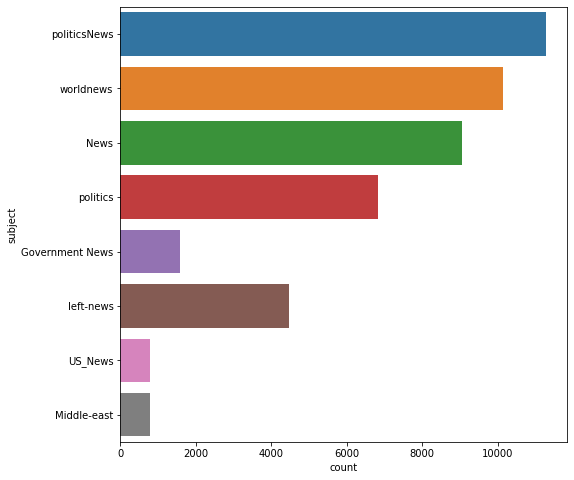

In [33]:
# Use seaborn to plot the number of samples in 'subject'!
# This barchart is based on news subject

plt.figure(figsize = (8, 8))
sns.countplot(y = "subject", data = df)

###### Plot the count plot for fake vs. true news

<AxesSubplot:xlabel='count', ylabel='isreal'>

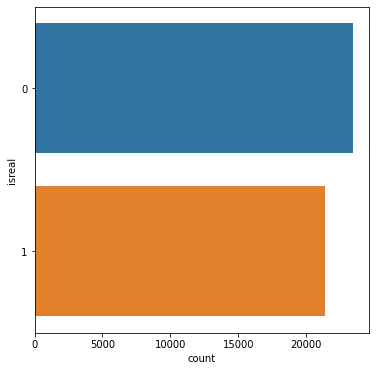

In [34]:
# Use seaborn to plot show a counts plot for fake vs. true as indicated by 'isreal' column!
# # This barchart is based on news classification label i.e. "isreal"!

plt.figure(figsize = (6, 6))
sns.countplot(y = "isreal", data = df)

##### Note: The dataset has fake news more than real news!

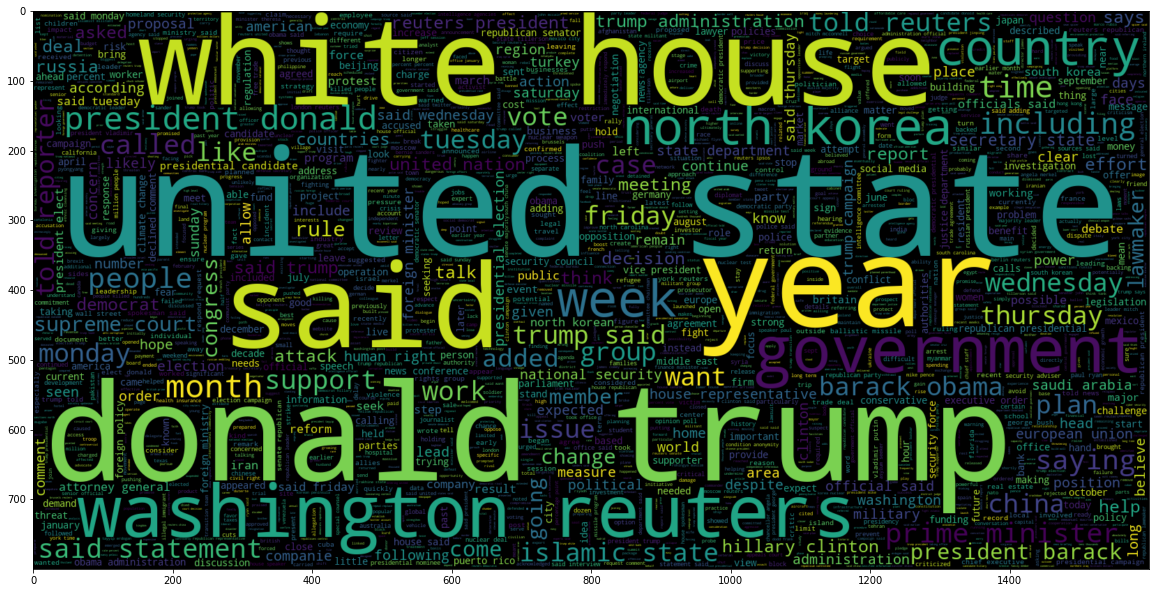

In [35]:
# Plot the wordcloud for text in Real news!

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = eng_stopwords).generate(" ".join(df[df.isreal == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

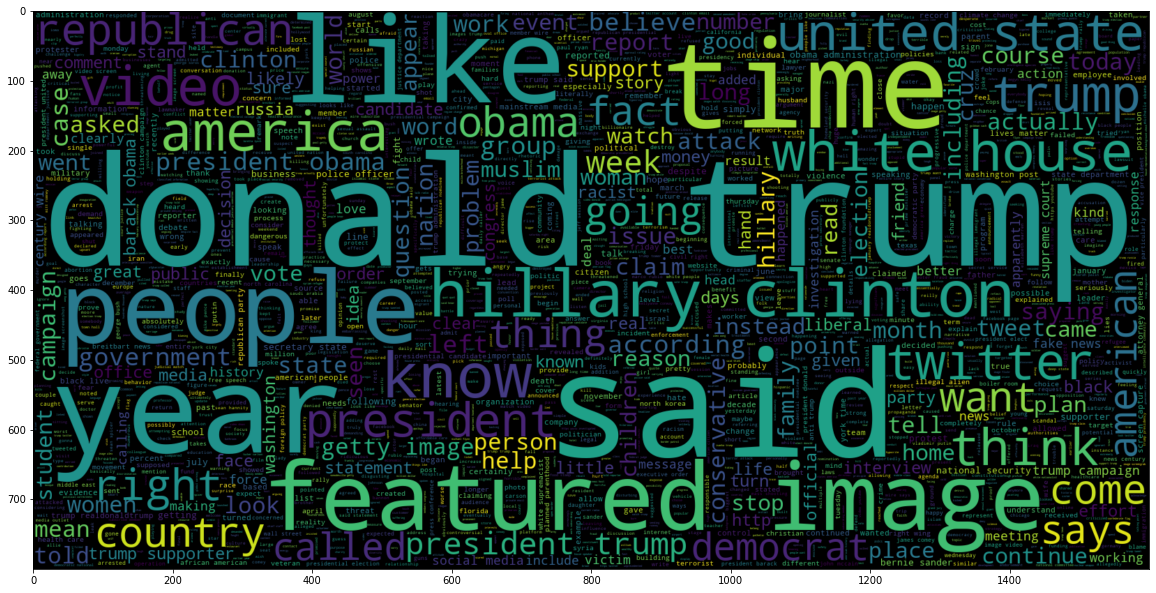

In [36]:
# Plot the wordcloud for text in Fake news!

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = eng_stopwords).generate(" ".join(df[df.isreal == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

## Feature-Engineering using Word Embeddings

<p style="font-size: 1em;"> 
Natural language processing (NLP) is a subfield of machine learning (ML). ML models can’t read and understand text in any human sense. Rather they should be numerically represent!
</p> 

#### To Perform Word Embeddings
- Find the maximum number of words in any document (news text contained in clean_joined)!
- Do a Data Split
- Performing Tokenization and Padding

In [37]:
# Start time for LSTM!

startTimeLSTM = time.time()

In [38]:
# Return all the tokens (each and every single word) as an array of tokens!

clean_joined_tokenized = nltk.word_tokenize(df['clean_joined'][1])
clean_joined_tokenized

['military',
 'accept',
 'transgender',
 'recruits',
 'monday',
 'pentagon',
 'washington',
 'reuters',
 'transgender',
 'people',
 'allowed',
 'time',
 'enlist',
 'military',
 'starting',
 'monday',
 'ordered',
 'federal',
 'courts',
 'pentagon',
 'said',
 'friday',
 'president',
 'donald',
 'trump',
 'administration',
 'decided',
 'appeal',
 'rulings',
 'blocked',
 'transgender',
 'federal',
 'appeals',
 'courts',
 'washington',
 'virginia',
 'week',
 'rejected',
 'administration',
 'request',
 'hold',
 'orders',
 'lower',
 'court',
 'judges',
 'requiring',
 'military',
 'begin',
 'accepting',
 'transgender',
 'recruits',
 'justice',
 'department',
 'official',
 'said',
 'administration',
 'challenge',
 'rulings',
 'department',
 'defense',
 'announced',
 'releasing',
 'independent',
 'study',
 'issues',
 'coming',
 'weeks',
 'litigate',
 'interim',
 'appeal',
 'occurs',
 'administration',
 'decided',
 'wait',
 'study',
 'continue',
 'defend',
 'president',
 'lawful',
 'authority',
 

In [39]:
# To get the maximum length of document needed to create word embeddings:
# - Iterate over the dataframe clean_joined, 
# - it is 4405!

maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)

print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4404


In [40]:
# Visualize the distribution of number of words in a text

"""
import plotly.express as px #interactive visualizations
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()
"""

'\nimport plotly.express as px #interactive visualizations\nfig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)\nfig.show()\n'

## Data Split

In [41]:
# Identify the independent and dependent variables!

X = df.clean_joined
y = df.isreal

In [42]:
## split data into test and train

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Performing Tokenization and Padding
- Necessary for LSTM

In [43]:
from nltk import word_tokenize

In [44]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words

# This represents the vocab_size or MAX_NB_WORDS!
# total_words = 108704!

tokenizer = Tokenizer(num_words = total_words)

tokenizer.fit_on_texts(X_train)

# Transforms each text in texts to a sequence of integers!
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [45]:
len(train_sequences)

35918

In [46]:
len(test_sequences)

8980

In [47]:
# Print a sequence of integers for "clean_joined" text in the 1st row!

print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [48]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
# Make sure all different samples have the same length (fillted 0 s for missing)

MAX_SEQUENCE_LENGTH = 40

# pad_sequences is used to ensure that all sequences in a list have the same length!
padded_train = pad_sequences(train_sequences, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = MAX_SEQUENCE_LENGTH, truncating = 'post') 

In [49]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ", doc)

The padded encoding for document 1  is :  [  657    19   827  1837     5   108  1134    27  1752   657  2203  1193
   111     1  6509   657  2354   166   972    53   206   156  1773   972
  1773   155     5   105   490   245     1   590    20   930  3169  1773
  1730    49 10347  4917]
The padded encoding for document 2  is :  [    1  5351  3070     6  6062   375  2337   433   295   499   479   317
    83     3 11333   917   614  9803    83    97  2265 14702   913   317
  2436   352     3     6    14   365  4405   479  2655  3249  1071  1031
   159   112  2445     3]


<hr style="height:20px">

## Define Functios to Assess Trained Model Performance!
- print_metrics(y_test, prediction, ML_modelName):
- visualize_confusionMatrix(y_test, prediction, ML_modelName):

- NB: To be called by other ML models

In [50]:
"""
# Getting the accuracy and f1_score metrcis!
"""
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# This method will be used to print the metrcis for diffeent model
def print_metrics(y_test, prediction, ML_modelName):
    
    accuracy = accuracy_score(list(y_test), prediction)
    print(ML_modelName +" Model Accuracy : ", accuracy)
    
    F1_measure = f1_score(list(y_test), prediction, average="macro")
    print(ML_modelName +" Model f1_score : ", F1_measure)
 
# ==================================

"""
## The Confusion Matrix Visualization Function
"""
def visualize_confusionMatrix(y_test, prediction, ML_modelName):

    cm = confusion_matrix(y_test, prediction)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, fmt='d', cmap='YlGnBu')

    ax.set_title('Confusion Matrix for: '+ ML_modelName)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    print(ML_modelName + ' Confusion Matrix: \n', confusion_matrix(y_test, prediction))

<hr style="height:20px">

## Create, Build and Train all Models
- LSTM
- LogisticRegression (Baseline)
- XGBoost

<hr style="height:10px">

## Implementaion using LSTM

#### LSTM Model Creation

In [51]:
# Sequential Model
modelLSTM = Sequential()

# create the embedding layer
EMBEDDING_DIM = 128
#MAX_SEQUENCE_LENGTH = 600

# total_words: it represents the vocab_size or the MAX_NB_WORDS!
embedding_layer = Embedding(total_words, output_dim = EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH)

# Stack the LSTM model layers!
modelLSTM.add(embedding_layer)
modelLSTM.add(Dropout(0.3))

# Either LSTM or Bi-Directional RNN and LSTM
#model.add(Bidirectional(LSTM(128))) # no of neurons
modelLSTM.add(LSTM(128)) # no of neurons
modelLSTM.add(Dropout(0.3))

# Dense layers
modelLSTM.add(Dense(128, activation = 'relu'))
modelLSTM.add(Dense(1, activation= 'sigmoid')) # reason: we do binary classification here

In [52]:
# Moel.compile: it defines the loss function, the optimizer and the metrics

modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           13913984  
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 14,062,209
Trainable params: 14,062,209
Non-trainable params: 0
____________________________________________

In [53]:
total_words

108703

In [54]:
type(y_train)

pandas.core.series.Series

In [55]:
# Convert y_train input to an array!

y_train_arr = np.asarray(y_train)
#print(y_train_arr.shape)

#### LSTM Model Training

In [56]:
# Train/Fit the LSTM model - Even it is better to try with more epochs!

modelLSTM.fit(padded_train, y_train_arr, batch_size = 64, validation_split = 0.1, epochs = 10)

Epoch 1/10
506/506 [==============================] - 119s 231ms/step - loss: 0.0433 - acc: 0.9813 - val_loss: 0.0044 - val_acc: 0.9994
Epoch 2/10
506/506 [==============================] - 108s 213ms/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.0076 - val_acc: 0.9994
Epoch 3/10
506/506 [==============================] - 118s 234ms/step - loss: 0.0023 - acc: 0.9998 - val_loss: 0.0056 - val_acc: 0.9994
Epoch 4/10
506/506 [==============================] - 133s 262ms/step - loss: 0.0163 - acc: 0.9970 - val_loss: 0.0130 - val_acc: 0.9983
Epoch 5/10
506/506 [==============================] - 147s 290ms/step - loss: 0.0158 - acc: 0.9968 - val_loss: 0.0093 - val_acc: 0.9989
Epoch 6/10
506/506 [==============================] - 134s 265ms/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0075 - val_acc: 0.9992
Epoch 7/10
506/506 [==============================] - 133s 262ms/step - loss: 0.0023 - acc: 0.9995 - val_loss: 0.0047 - val_acc: 0.9989
Epoch 8/10
506/506 [============================

#### Predictions using LSTM

In [57]:
padded_test.shape

(8980, 40)

In [58]:
# Make predictions!

predLstm = modelLSTM.predict(padded_test)
predLstm.shape

In [60]:
# if the predicted value is > 0.5, then it is real news else it is fake news!

predictions = []

for i in range(len(predLstm)):
    if predLstm[i].item() > 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [62]:
len(predLstm)

8980

In [61]:
# End of calculating running time for LSTM!

print("--- LSTM running time is: %s seconds ---" % (time.time() - startTimeLSTM))

--- LSTM running time is: 1373.545404434204 seconds ---


#### LSTM Model Evaluation

In [63]:
# Print LSTM Metrics: Old: Accuracy is 0.9964365256124722, F1_measure is 0.9912933179310266!

print_metrics(y_test, predictions, "LSTM")

LSTM Model Accuracy :  0.9969933184855234
LSTM Model f1_score :  0.9969896143183905


LSTM Confusion Matrix: 
 [[4634    9]
 [  18 4319]]


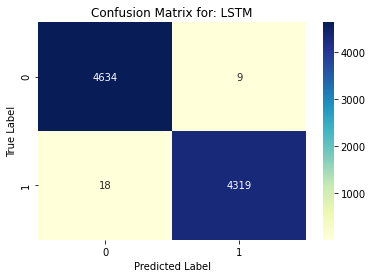

In [64]:
# Visualize the Confusion Matrix for LSTM!
# The same results were optained - even before adding the embedding layer!!!

visualize_confusionMatrix(y_test, predictions, "LSTM")

<hr style="height:10px">

## Implementaion using LogisticRegression ML Model

###  Import the related python libraries!

In [65]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn import metrics

In [66]:
# Start time for LR 
startTimeLR= time.time()

In [67]:
#StratifiedKFold is a variation of KFold!

# n_repeats, default=10, stabds for the number of times cross-validator needs to be repeated.

SKF = StratifiedKFold(n_splits=10, random_state=42, shuffle=True) #n_repeats=3 or 5

In [68]:
#### Feature represnation using TF-IDF

### LogisticRegression Model Creation

In [69]:
#LR = LogisticRegression()

pipelineLR = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

### Data Split

In [70]:
# Train and Test data splits!

# With pipelineLR approach!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### LogisticRegression Model Training

In [71]:
# Fitting the LR to the Training set!

# Without Pipeline option!
#LR = LR.fit(X_train, y_train)

# With Pipeline option!
modelLR = pipelineLR.fit(X_train, y_train)

In [72]:
# Perform the training using KFolds cross validation method!

scores = cross_val_score(modelLR, X_train, y_train, scoring='accuracy', cv=SKF, n_jobs=-1)
print(f' Accuracy of LogisticRegression : {round (np.mean(scores) ,4)}%')

 Accuracy of LogisticRegression : 0.9844%


### Predictions using LogisticRegression

In [73]:
# y_pred Without Pipeline
#predLR = LR.predict(X_test)

# y_pred With Pipeline
predLR = modelLR.predict(X_test) # predLR is an array of 0,1!

In [74]:
# End of calculating running time for XGBoost!

print("--- LogisticRegression running time is: %s seconds ---" % (time.time() - startTimeLR))

--- LogisticRegression running time is: 77.88147807121277 seconds ---


In [75]:
# Print LogisticRegression Metrics!

print_metrics(y_test, predLR, "Logistic Regression")

Logistic Regression Model Accuracy :  0.9848552338530067
Logistic Regression Model f1_score :  0.9848289186291508


Logistic Regression Confusion Matrix: 
 [[4609   87]
 [  49 4235]]


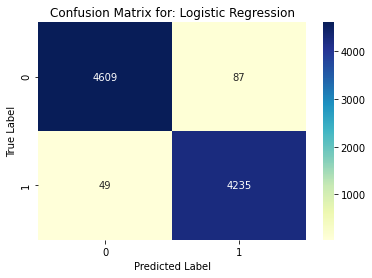

In [76]:
# Visualize the Confusion Matrix for LogisticRegression!

visualize_confusionMatrix(y_test, predLR, "Logistic Regression")

<hr style="height:10px">

## Implementaion using XGBoost ML Model

###  Import the related Py Libraries

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score


from jcopml.tuning.space import Real, Integer
from xgboost import XGBClassifier

In [78]:
# Start time for XGBoost 
startTimeXGBoost = time.time()

In [79]:
#StratifiedKFold is a variation of KFold!

# Note: n_repeats, default=10,
#cv = KFold(n_splits=10, random_state=42, shuffle=True)
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True) #n_repeats=3 or 5

### Data Split

In [80]:
## The data split into test and train!

# Split that suits a Pipeline!

# With tratify=y!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

###  The XGBoost Model Creation
- Use the same TF-IDF Feature represnation!

In [81]:
## Defien a pipline with: TfidfVectorizer + XGBClassifier!

"""
Note: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release.
Thus, passing the option use_label_encoder=False was enabled when constructing XGBClassifier object!
"""
XGb = XGBClassifier(n_jobs=-1, random_state=42, use_label_encoder=False)

pipelineXGBoost = Pipeline([
    ('prep', TfidfVectorizer(tokenizer=word_tokenize, stop_words=eng_stopwords)),
    ('algo', XGb)
])

#### XGBoost parameter tuning - deactivated as per the provided README file!

In [82]:
"""
# The xgboost parameters!

parameter = {
 'algo__max_depth': Integer(low=12, high=20),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__n_estimators': Integer(low=195, high=210),
 'algo__subsample': Real(low=0.5, high=1, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform')
}
"""
"""
# XGBoost-->n_iter vs. LR-->n_repeats!!!

# n_iter default=10, cv/cross-validation default=None, n_jobs=-1 measns use all processors!
# I used n_iter=5 because of bad running time with 10, 50!

modelXGBoost = RandomizedSearchCV(pipelineXGBoost, parameter, cv=2, n_iter=5, n_jobs=-1, verbose=0, random_state=42)#cv=5
"""

'\n# XGBoost-->n_iter vs. LR-->n_repeats!!!\n\n# n_iter default=10, cv/cross-validation default=None, n_jobs=-1 measns use all processors!\n# I used n_iter=5 because of bad running time with 10, 50!\n\nmodelXGBoost = RandomizedSearchCV(pipelineXGBoost, parameter, cv=2, n_iter=5, n_jobs=-1, verbose=0, random_state=42)#cv=5\n'

### XGBoost Model Training

In [83]:
modelXGBoost = pipelineXGBoost.fit(X_train, y_train)

[15:06:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [84]:
# Perform the training using KFolds cross validation method

scores = cross_val_score(modelXGBoost, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print(f' Accuracy of XGBoost : {round (np.mean(scores) ,4)}%')

 Accuracy of XGBoost : 0.997%


In [85]:
# Fitting the XGBoost to the Training set - with parameter tuning!

#modelXGBoost.fit(X_train, y_train)

## XGBoost optimal parameters

#print(modelXGBoost.best_params_)

### Predictions using XGBoost

In [86]:
predXGB = modelXGBoost.predict(X_test)

In [87]:
# End of calculating running time for XGBoost!

print("--- XGBoost running time is: %s seconds ---" % (time.time() - startTimeXGBoost))

--- XGBoost running time is: 428.38655710220337 seconds ---


###  XGBoost Model Evalutation

In [88]:
# Print XGBoost Metrics!

print_metrics(y_test, predXGB, "XGBoost")

XGBoost Model Accuracy :  0.9981069042316258
XGBoost Model f1_score :  0.9981028915047678


XGBClassifier Confusion Matrix: 
 [[4688    8]
 [   9 4275]]


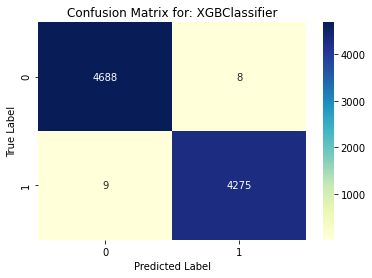

In [89]:
# Visualization the Confusion Matrix for XGBClassifier!

visualize_confusionMatrix(y_test, predXGB, "XGBClassifier")

<hr style="height:20px">

## Summary

In this work, I have compared three ML models, namely: Logistic Regression, Long-Short Term Memory (LSTM), and XGBoost.

-  Logistic Regression has already shown a good performance in classification task. It was also applied in [1] to detect fake news, but it has rather shown moderate results. As per this work, I am intending to use it as a baseline model. <br>


- LSTM is an advanced version of artificial Recurrent Neural Network (RNN), which makes it easier to remember past data in memory. LSTM is a well-suited model for sequential data [2]. It has been frequently used for solving Natural language processing (NLP) problems, such as sequence/text labeling, sentiment analysis and automatic diacritization (aka short vowels restoration). Deep neural networks are showing dominant results in several domains. The expectation is to get impressive results from LSTM.


- XGBoost is an implementation of gradient boosted decision trees designed for speed and performance [3]. I am using it because (i) it was used by [4] for fake news detection (ii) from personal experience, it has already shown good results in predicting life insurance tariffs (iii) as reported by [3], it has recently been dominating applied machine learning and Kaggle competitions for structured or tabular data. The expectation is to get fancy results from XGBoost.

Nowadays is the era of state-of-the-art (SotA) transformer-based NLP models [5]. Transformers become more and more dominant [2]. Thus, another excellent and recommended model is Bidirectional Encoder Representations from Transformers, a BERT-based deep learning approach. For the completion of this ML task, I have tried the three models mentioned above. However, for my other NLP research tasks, I would use fine-tuning transformer-based approaches.


## Appendix: Showcase using PyCaret!

As a showcase on how easy to use, the low-code python library or PyCaret. I have included an extra NB "machine_learning_task_pycaret.ipynb". For the purpose of this showcase, and because of computation resources (including memory limitations) on my local machine, I have used the news "title" as a dependent variable and with a sample of 2000 rows that were arbitrarily selected from the dataset! I have compared the following models:

- LogisticRegression


- XGBoost


- LightGBM

## References

1-
https://www.ijeat.org/wp-content/uploads/papers/v9i1/A2633109119.pdf

2-
https://github.com/wutonytt/Fake-News-Detection


3-
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

4-
http://ceur-ws.org/Vol-2936/paper-51.pdf

5-
https://neptune.ai/blog/tips-to-train-nlp-models